In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Set plotting style
sns.set(style='whitegrid')

In [2]:
# Load the data from the text file
data = pd.read_csv('data/raw/PET/PET.txt', sep='\t', header=None, names=['json_str'])

# Function to parse JSON strings
def parse_json_str(json_str):
    return json.loads(json_str)

# Apply the function to parse the JSON strings
parsed_data = data['json_str'].apply(parse_json_str)

# Create a DataFrame from the parsed JSON data
df = pd.json_normalize(parsed_data)

# Display the first few rows of the DataFrame
print(df.head())

                       series_id  \
0  PET.EMM_EPMPR_PTE_Y35NY_DPG.W   
1  PET.EMM_EPMPR_PTE_Y44HO_DPG.W   
2  PET.EMM_EPMMR_PTE_R5XCA_DPG.W   
3  PET.EMM_EPMMR_PTE_Y05LA_DPG.W   
4  PET.EMM_EPMMR_PTE_Y05SF_DPG.W   

                                                name               units  f  \
0  New York Harbor Premium Reformulated Retail Ga...  Dollars per Gallon  W   
1  Houston, TX Premium Reformulated Retail Gasoli...  Dollars per Gallon  W   
2  West Coast (PADD 5) Except California Midgrade...  Dollars per Gallon  W   
3  Los Angeles, CA Midgrade Reformulated Retail G...  Dollars per Gallon  W   
4  San Francisco, CA Midgrade Reformulated Retail...  Dollars per Gallon  W   

  unitsshort                                        description copyright  \
0      $/gal  New York Harbor Premium Reformulated Retail Ga...      None   
1      $/gal  Houston, TX Premium Reformulated Retail Gasoli...      None   
2      $/gal  West Coast (PADD 5) Except California Midgrade...      None   


In [3]:
df.columns

Index(['series_id', 'name', 'units', 'f', 'unitsshort', 'description',
       'copyright', 'source', 'iso3166', 'geography', 'start', 'end',
       'last_updated', 'data', 'geography2', 'category_id',
       'parent_category_id', 'notes', 'childseries'],
      dtype='object')

In [4]:
# Sample this list to see ten random elements
df_list = df['data'].tolist()
print(df_list[:2])

[[['20240617', 4.306], ['20240610', 4.328], ['20240603', 4.367], ['20240527', 4.412], ['20240520', 4.399], ['20240513', 4.434], ['20240506', 4.457], ['20240429', 4.469], ['20240422', 4.472], ['20240415', 4.224], ['20240408', 4.177], ['20240401', 4.152], ['20240325', 4.185], ['20240318', 4.108], ['20240311', 4.098], ['20240304', 4.101], ['20240226', 4.067], ['20240219', 4.085], ['20240212', 4.032], ['20240205', 4.031], ['20240129', 4.041], ['20240122', 3.988], ['20240115', 3.986], ['20240108', 4.038], ['20240101', 4.053], ['20231225', 4.074], ['20231218', 4.059], ['20231211', 4.127], ['20231204', 4.2], ['20231127', 4.231], ['20231120', 4.226], ['20231113', 4.236], ['20231106', 4.295], ['20231030', 4.346], ['20231023', 4.384], ['20231016', 4.444], ['20231009', 4.473], ['20231002', 4.529], ['20230925', 4.568], ['20230918', 4.632], ['20230911', 4.561], ['20230904', 4.544], ['20230828', 4.571], ['20230821', 4.58], ['20230814', 4.576], ['20230807', 4.576], ['20230731', 4.538], ['20230724', 4

In [5]:
# Explode the 'data' column to separate rows for each date-value pair
df = df.explode('data')
df.head()

,series_id,name,units,f,unitsshort,description,copyright,source,iso3166,geography,start,end,last_updated,data,geography2,category_id,parent_category_id,notes,childseries
0,PET.EMM_EPMPR_PTE_Y35NY_DPG.W,New York Harbor Premium Reformulated Retail Ga...,Dollars per Gallon,W,$/gal,New York Harbor Premium Reformulated Retail Ga...,None,"EIA, U.S. Energy Information Administration",USA-NY,USA-NY,20000605,20240617,2024-06-17T22:10:18-04:00,"[20240617, 4.306]",NaN,NaN,NaN,NaN,NaN
0,PET.EMM_EPMPR_PTE_Y35NY_DPG.W,New York Harbor Premium Reformulated Retail Ga...,Dollars per Gallon,W,$/gal,New York Harbor Premium Reformulated Retail Ga...,None,"EIA, U.S. Energy Information Administration",USA-NY,USA-NY,20000605,20240617,2024-06-17T22:10:18-04:00,"[20240610, 4.328]",NaN,NaN,NaN,NaN,NaN
0,PET.EMM_EPMPR_PTE_Y35NY_DPG.W,New York Harbor Premium Reformulated Retail Ga...,Dollars per Gallon,W,$/gal,New York Harbor Premium Reformulated Retail Ga...,None,"EIA, U.S. Energy Information Administration",USA-NY,USA-NY,20000605,20240617,2024-06-17T22:10:18-04:00,"[20240603, 4.367]",NaN,NaN,NaN,NaN,NaN
0,PET.EMM_EPMPR_PTE_Y35NY_DPG.W,New York Harbor Premium Reformulated Retail Ga...,Dollars per Gallon,W,$/gal,New York Harbor Premium Reformulated Retail Ga...,None,"EIA, U.S. Energy Information Administration",USA-NY,USA-NY,20000605,20240617,2024-06-17T22:10:18-04:00,"[20240527, 4.412]",NaN,NaN,NaN,NaN,NaN
0,PET.EMM_EPMPR_PTE_Y35NY_DPG.W,New York Harbor Premium Reformulated Retail Ga...,Dollars per Gallon,W,$/gal,New York Harbor Premium Reformulated Retail Ga...,None,"EIA, U.S. Energy Information Administration",USA-NY,USA-NY,20000605,20240617,2024-06-17T22:10:18-04:00,"[20240520, 4.399]",NaN,NaN,NaN,NaN,NaN


In [6]:
# Select distinct series_id, name, units
df_series = df[['series_id', 'name', 'units']].drop_duplicates()
df_series.head()

,series_id,name,units
0,PET.EMM_EPMPR_PTE_Y35NY_DPG.W,New York Harbor Premium Reformulated Retail Ga...,Dollars per Gallon
1,PET.EMM_EPMPR_PTE_Y44HO_DPG.W,"Houston, TX Premium Reformulated Retail Gasoli...",Dollars per Gallon
2,PET.EMM_EPMMR_PTE_R5XCA_DPG.W,West Coast (PADD 5) Except California Midgrade...,Dollars per Gallon
3,PET.EMM_EPMMR_PTE_Y05LA_DPG.W,"Los Angeles, CA Midgrade Reformulated Retail G...",Dollars per Gallon
4,PET.EMM_EPMMR_PTE_Y05SF_DPG.W,"San Francisco, CA Midgrade Reformulated Retail...",Dollars per Gallon


In [7]:
# Filter df to only include name containing 'Louisiana' and units in Dollars per Gallon
df = df[df['name'].str.contains('Louisiana Total') & df['units'].str.contains('Dollars per Gallon')]
df

,series_id,name,units,f,unitsshort,description,copyright,source,iso3166,geography,start,end,last_updated,data,geography2,category_id,parent_category_id,notes,childseries
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202203, 3.09]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202202, 2.598]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202201, 2.331]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202112, 2.191]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202111, 2.332]",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,1984,2021,2022-04-01T10:51:55-04:00,"[1988, 0.552]",NaN,NaN,NaN,NaN,NaN
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,1984,2021,2022-04-01T10:51:55-04:00,"[1987, 0.566]",NaN,NaN,NaN,NaN,NaN
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,1984,2021,2022-04-01T10:51:55-04:00,"[1986, 0.511]",NaN,NaN,NaN,NaN,NaN
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,1984,2021,2022-04-01T10:51:55-04:00,"[1985, 0.832]",NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop rows where 'data' is NaN or not a list
df = df.dropna(subset=['data'])
df = df[df['data'].apply(lambda x: isinstance(x, list) and len(x) == 2)]
df.head()

,series_id,name,units,f,unitsshort,description,copyright,source,iso3166,geography,start,end,last_updated,data,geography2,category_id,parent_category_id,notes,childseries
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202203, 3.09]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202202, 2.598]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202201, 2.331]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202112, 2.191]",NaN,NaN,NaN,NaN,NaN
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,198301,202203,2022-06-01T10:50:11-04:00,"[202111, 2.332]",NaN,NaN,NaN,NaN,NaN


In [9]:
# Split 'data' column into 'date' and 'value'
df[['date', 'value']] = pd.DataFrame(df['data'].tolist(), index=df.index)
df

,series_id,name,units,f,unitsshort,description,copyright,source,iso3166,geography,...,end,last_updated,data,geography2,category_id,parent_category_id,notes,childseries,date,value
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202203, 3.09]",NaN,NaN,NaN,NaN,NaN,202203,3.090
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202202, 2.598]",NaN,NaN,NaN,NaN,NaN,202202,2.598
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202201, 2.331]",NaN,NaN,NaN,NaN,NaN,202201,2.331
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202112, 2.191]",NaN,NaN,NaN,NaN,NaN,202112,2.191
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202111, 2.332]",NaN,NaN,NaN,NaN,NaN,202111,2.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1988, 0.552]",NaN,NaN,NaN,NaN,NaN,1988,0.552
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1987, 0.566]",NaN,NaN,NaN,NaN,NaN,1987,0.566
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1986, 0.511]",NaN,NaN,NaN,NaN,NaN,1986,0.511
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1985, 0.832]",NaN,NaN,NaN,NaN,NaN,1985,0.832


In [10]:
# Convert 'date' to datetime, coercing errors to NaT
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
# Convert 'value' to a numeric type, coercing errors to NaN
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df

,series_id,name,units,f,unitsshort,description,copyright,source,iso3166,geography,...,end,last_updated,data,geography2,category_id,parent_category_id,notes,childseries,date,value
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202203, 3.09]",NaN,NaN,NaN,NaN,NaN,NaT,3.090
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202202, 2.598]",NaN,NaN,NaN,NaN,NaN,NaT,2.598
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202201, 2.331]",NaN,NaN,NaN,NaN,NaN,NaT,2.331
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202112, 2.191]",NaN,NaN,NaN,NaN,NaN,2021-01-02,2.191
93062,PET.EMA_EPM0_PWG_SLA_DPG.M,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,M,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,202203,2022-06-01T10:50:11-04:00,"[202111, 2.332]",NaN,NaN,NaN,NaN,NaN,2021-01-01,2.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1988, 0.552]",NaN,NaN,NaN,NaN,NaN,NaT,0.552
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1987, 0.566]",NaN,NaN,NaN,NaN,NaN,NaT,0.566
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1986, 0.511]",NaN,NaN,NaN,NaN,NaN,NaT,0.511
116794,PET.EMA_EPM0_PWA_SLA_DPG.A,Louisiana Total Gasoline Wholesale/Resale Pric...,Dollars per Gallon,A,$/gal,Louisiana Total Gasoline Wholesale/Resale Pric...,None,"EIA, U.S. Energy Information Administration",USA-LA,USA-LA,...,2021,2022-04-01T10:51:55-04:00,"[1985, 0.832]",NaN,NaN,NaN,NaN,NaN,NaT,0.832


In [11]:
# Extract relevant columns and preprocess the data
df['Date'] = pd.to_datetime(df['date'])
df['Price'] = df['value']
df = df[['Date', 'Price']].sort_values(by='Date').reset_index(drop=True)
df.tail()

,Date,Price
4145,NaT,0.552
4146,NaT,0.566
4147,NaT,0.511
4148,NaT,0.832
4149,NaT,0.841


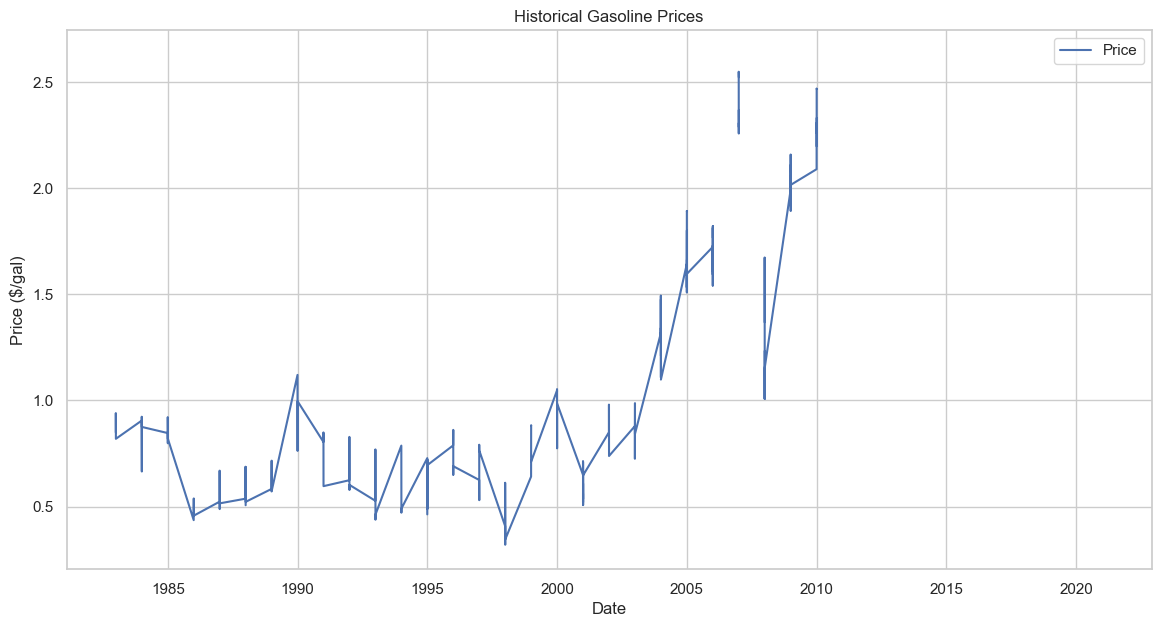

In [12]:
# Plot historical prices
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Price'], label='Price')
plt.title('Historical Gasoline Prices')
plt.xlabel('Date')
plt.ylabel('Price ($/gal)')
plt.legend()
plt.grid(True)
plt.show()

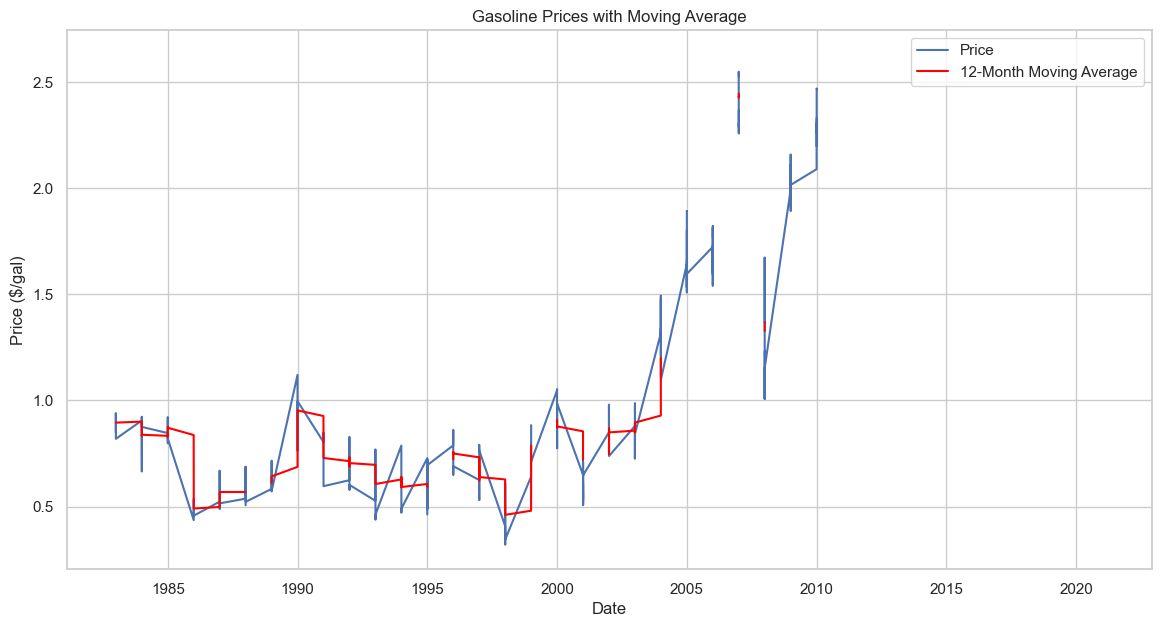

In [13]:
# Moving Average
df['Price_MA'] = df['Price'].rolling(window=12).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Price'], label='Price')
plt.plot(df['Date'], df['Price_MA'], label='12-Month Moving Average', color='red')
plt.title('Gasoline Prices with Moving Average')
plt.xlabel('Date')
plt.ylabel('Price ($/gal)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# # Save the model
# import joblib
# joblib.dump(model, 'models/oil_price_forecast_model.pkl')